In [1]:
import os
from matplotlib import test
import tensorflow as tf
# import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tensorflow.keras import datasets, layers, models

In [2]:
data_path = "../../../ISIC_Data/ISIC-2017_Training_Data/*.jpg"
mask_path = "../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/*.png"

In [72]:
def prepareData(filenames):
    new_img = tf.io.read_file(filenames)
    raw_image = tf.io.decode_jpeg(new_img, channels=3)

    # Resize
    raw_image = tf.image.resize_with_pad(raw_image, 480, 480)

    # Normalise
    raw_image = raw_image / 255.0

    return raw_image


def prepareMasks(filenames):
    new_img = tf.io.read_file(filenames)
    raw_image = tf.io.decode_png(new_img, channels=1)

    # Resize
    raw_image = tf.image.resize_with_pad(raw_image, 480, 480)

    # Normalise
    raw_image = raw_image / 255.0

    # Set image thresholds
    raw_image = tf.where(raw_image >= 0.5, 1.0, 0.0)

    return raw_image

In [70]:
ISIC_Data = tf.data.Dataset.list_files(data_path, shuffle=False)
preData = ISIC_Data.map(prepareData)

Mask_Data = tf.data.Dataset.list_files(mask_path, shuffle=False)
preMasks = Mask_Data.map(prepareMasks)

In [88]:
def indicies_by_value(value):
    return tf.where(tf.equal(value, True))[:, -1]

def mask_to_bounding_box(mask_image):
    # Takes mask as input and outputs bounding box Tensor
    
    rows = tf.math.count_nonzero(mask_image, axis=0, keepdims=None, dtype=bool)
    rows = tf.squeeze(rows, axis=1)
    row_index = indicies_by_value(rows)

    columns = tf.math.count_nonzero(mask_image, axis=1, keepdims=None, dtype=bool)
    columns = tf.squeeze(columns, axis=1)
    # Convert to indicies
    col_index = indicies_by_value(columns)

    y_min = col_index[0]    # First mask pixel
    y_max = col_index[-1]   # Last mask pixel
    x_min = row_index[0]    
    x_max = row_index[-1]

    image = tf.image.convert_image_dtype(mask_image, dtype=tf.float32)
    img = tf.expand_dims(image, axis=0)
    img = tf.reshape(img, shape=[1, 480, 480, 1])

    box = tf.stack([y_min, x_min, y_max, x_max], axis=0)
    box = tf.math.divide(box, 480)
    box = box.numpy()
    box = box.reshape([1,1,4])

    return box
    # box = np.array([0.1, 0.2, 0.5, 0.9])
    # box = tf.convert_to_tensor(box, dtype="float32")
    # box = tf.reshape(box, [1, 1, 4])

image = prepareMasks('../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000000_segmentation.png')
mask_to_bounding_box(image)


array([[[0.16875   , 0.05      , 0.74166667, 0.87708333]]])

In [96]:
def box_details_extraction(box):
    # Determine center coordinates
    full_index = tf.math.multiply(box, 480)
    x_size = tf.math.subtract(full_index[0][0][3], full_index[0][0][1])
    y_size = tf.math.subtract(full_index[0][0][2], full_index[0][0][0])

    center_x = tf.math.divide(x_size, 2.0)
    center_y = tf.math.divide(y_size, 2.0)

    return center_x, center_y, x_size, y_size

image = prepareMasks('../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000000_segmentation.png')
box = mask_to_bounding_box(image)

print(box_details_extraction(box))

(<tf.Tensor: shape=(), dtype=float64, numpy=198.5>, <tf.Tensor: shape=(), dtype=float64, numpy=137.5>, <tf.Tensor: shape=(), dtype=float64, numpy=397.0>, <tf.Tensor: shape=(), dtype=float64, numpy=275.0>)


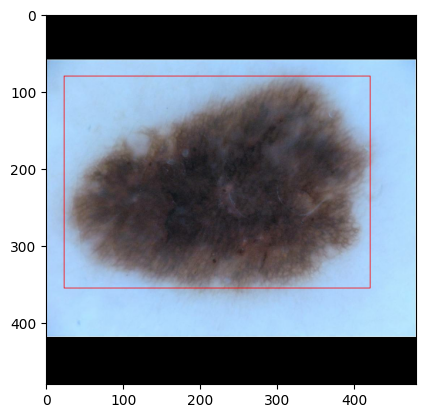

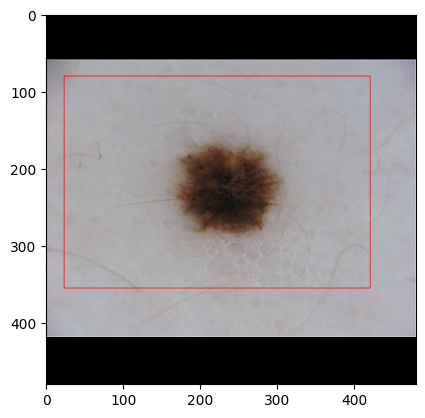

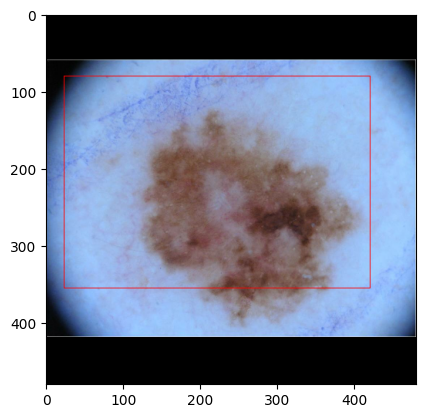

In [97]:
# for i in preData.take(1):
#     plt.imshow(i.numpy())
#     plt.show()

# for j in preMasks.take(1):
#     plt.imshow(j.numpy())
#     plt.show()

# for element in preData.as_numpy_iterator(): 
# for image in preData.take(3):

batches_data = preData.batch(1)
batches_mask = preMasks.batch(1)

for image in batches_data.take(3):
    # print(image)
    # print(images.shape)
    # img = tf.zeros([1, 480, 480, 3])
    # element.reshape([1, 480, 480, 3]) 
    # print(element.shape)

    # box = np.array([0.1, 0.2, 0.5, 0.9])
    # box = tf.convert_to_tensor(box, dtype="float32")
    # box = tf.reshape(box, [1, 1, 4])

    box = mask_to_bounding_box(prepareMasks('../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000000_segmentation.png'))
    # box = tf.math.divide(box, 480)

    colour = [[1.0, 0.0, 0.0]]

    # image = tf.cast(image, tf.float32)

    bbox = tf.image.draw_bounding_boxes(image, box, colour)

    # boxes = box.reshape([1, 1, 4])
    # colours = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
    # boxes = tf.convert_to_tensor([1, 1, [0.1, 0.2, 0.5, 0.9]])

    # print(boxes)

    # bbox = tf.image.draw_bounding_boxes(img, boxes, np.array([[1.0, 0, 0]]))

    # print(bbox.shape[1])

    # converted = np.array([bbox[1], bbox[2], bbox[3]])
    # print(converted.shape)
    plt.imshow(bbox.numpy()[0])
    plt.show()
    # break



In [ ]:
# YOLO Model

